# 8.1 序列模型

## 1.2 训练

In [11]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

# 1. 构造原始时间序列
生成时序数据： 使用正弦函数和一些噪音， 时间步为$1,...,1000$

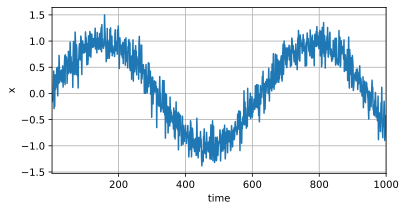

In [12]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
# 时间序列：正玄波 + 噪音0.2， N(0, 0.2)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

# 构造特征和标签（监督学习格式）

1. 监督学习样本对：$(X,y)$
2.

将这个序列转换为模型的特征－－标签（feature-label）对。

基于嵌入维度 $\tau$, 我们将数据映射为数据对 $y_t=x_t$ 和 $\mathbf{x}_t=[x_{t-\tau},...,x_{t-1}]$。

这比我们提供的数据样本少了 $\tau$个， 因为我们没有足够的历史记录来描述前 $\tau$个数据样本。

一个简单的解决办法是：
- 如果拥有足够长的序列就丢弃这几项；
- 另一个方法是用零填充序列。
- 在这里，我们仅使用前600个"特征－标签"对进行训练。

In [13]:
# 用前 4 个时间步的数据来预测第 5 个时间步的数据
tau = 4
# features: 形状为 (T - tau, tau)，即 (996, 4)，每一行是一个长度为 4 的输入序列
features = torch.zeros((T - tau, tau))
for i in range(tau):
    # i=0, x[0:996] -> x[0],x[1],...,x[995]
    # i=1, x[1:997] -> x[1],x[2],...,x[996]
    # i=2...i=3...
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

简单的结构： 拥有两个全连接层的MLP

In [14]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [15]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch +1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss): f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss:  0.064339
epoch 2, loss:  0.061993
epoch 3, loss:  0.055318
epoch 4, loss:  0.054446
epoch 5, loss:  0.052374


# 1.3 预测

## 一步预测（one-step-ahead prediction）

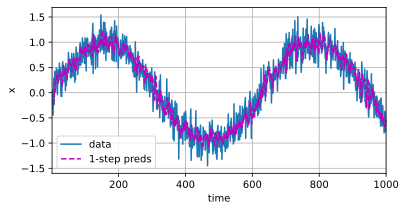

In [23]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()],
         'time', 'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

## 多步预测（multi-step-ahead prediction）

- 前 n_train + tau 个值直接复制自真实数据 x
    - n_train=600: 训练集大小
    - tau=4: 每次预测需要的历史窗口；
    - 所以 600+4=604 是“已知部分”，包括训练数据和初始历史；
    - 这些点不会被预测，而是作为后续预测的起点。

- 目标：从第 605 个时间点开始，逐步向前预测每一个点。

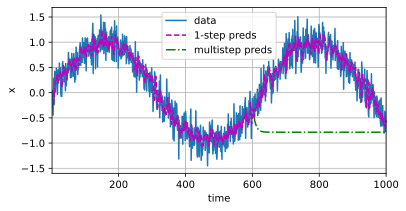

In [24]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

多步预测的另一种实现方式

在 step=64的时候，已经预测的非常不好了。


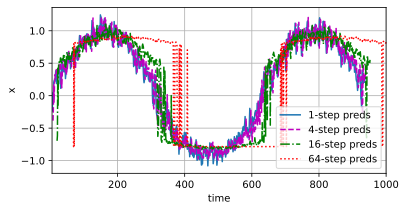

In [25]:
max_steps = 64
features = torch.zeros((T - tau - max_steps +1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i: i+T-tau-max_steps +1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i-tau: i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i ] for i in steps],
         [features[:, (tau + i -1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))